In [1]:
import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')
%matplotlib inline

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'confi

In [2]:
_d = np.load('../../data_train.npz')
X = _d['X']
Y = _d['Y']

In [3]:
print X.shape
print Y.shape

(5635, 104, 144)
(5635, 104, 144)


In [4]:
nsamples = X.shape[0]

train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.1)
#train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.25)
X_train = X[train_indices][:,None,:,:]
Y_train = Y[train_indices][:,None,:,:]
X_test = X[test_indices][:,None,:,:]
Y_test = Y[test_indices][:,None,:,:]

In [5]:
print X_train.shape
print Y_train.shape
print X_train.min(), X_train.max()

(5071, 1, 104, 144)
(5071, 1, 104, 144)
0.0 1.0


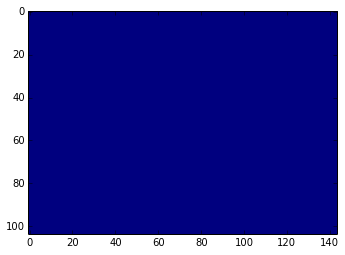

In [6]:
#pl.imshow(X_train[0].squeeze())
pl.imshow(Y_train[0].squeeze())

# Keras model

In [7]:
# channels first in keras
input_shape = X_train[0].shape
print input_shape

(1, 104, 144)


In [8]:
os.environ['KERAS_BACKEND'] = 'theano'
# TODO: Use float16 ?
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float16'
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, merge, RepeatVector, Permute, Reshape
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import LeakyReLU
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from keras.utils.layer_utils import print_summary

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 4007)


In [9]:
import theano
print theano.config.device

gpu0


In [10]:
input_img = Input(shape=input_shape)
x = Convolution2D(16, 3, 3, border_mode='same')(input_img)
x = LeakyReLU()(x)
#x = Convolution2D(16, 3, 3, border_mode='same')(x)
#x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
pool1 = Dropout(0.25, name='pool1')(x)

x = Convolution2D(32, 3, 3, border_mode='same')(pool1)
x = LeakyReLU()(x)
#x = Convolution2D(32, 3, 3, border_mode='same')(x)
#x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
pool2 = Dropout(0.25, name='pool2')(x)

x = Convolution2D(64, 3, 3, border_mode='same')(pool2)
x = LeakyReLU()(x)
#x = Convolution2D(64, 3, 3, border_mode='same')(x)
#x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
pool3 = Dropout(0.25, name='pool3')(x)


#x = merge([x, pool3], mode='sum')
x = Convolution2D(32, 3, 3, border_mode='same')(pool3)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

x = merge([x, pool2], mode='sum')
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

x = merge([x, pool1], mode='sum')
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

outmap = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same', name='outmap')(x)

model = Model(input_img, outmap)
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd, loss='binary_crossentropy')
#rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
#model.compile(optimizer=rmsprop, loss='binary_crossentropy')
model.compile(optimizer='adam', loss='binary_crossentropy')

print_summary(model.layers)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_1 (InputLayer)               (None, 1, 104, 144) 0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)    (None, 16, 104, 144)160         input_1[0][0]                    
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)            (None, 16, 104, 144)0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)      (None, 16, 52, 72)  0           leakyrelu_1[0][0]                
___________________________________________________________________________________________

In [11]:
#from IPython.display import SVG
#from keras.utils.visualize_util import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [12]:
history = model.fit(
    X_train, Y_train,
    batch_size=32,
    validation_data=(X_test, Y_test),
    nb_epoch=25 # 60
)

Train on 5071 samples, validate on 564 samples
Epoch 1/25
5071/5071 [==============================] - 30s - loss: 0.0863 - val_loss: 0.0709
Epoch 2/25
5071/5071 [==============================] - 30s - loss: 0.0531 - val_loss: 0.0475
Epoch 3/25
5071/5071 [==============================] - 30s - loss: 0.0448 - val_loss: 0.0527
Epoch 4/25
5071/5071 [==============================] - 30s - loss: 0.0392 - val_loss: 0.0427
Epoch 5/25
5071/5071 [==============================] - 30s - loss: 0.0371 - val_loss: 0.0343
Epoch 6/25
5071/5071 [==============================] - 26s - loss: 0.0340 - val_loss: 0.0330
Epoch 7/25
5071/5071 [==============================] - 16s - loss: 0.0326 - val_loss: 0.0328
Epoch 8/25
5071/5071 [==============================] - 16s - loss: 0.0315 - val_loss: 0.0287
Epoch 9/25
5071/5071 [==============================] - 16s - loss: 0.0305 - val_loss: 0.0281
Epoch 10/25
5071/5071 [==============================] - 16s - loss: 0.0300 - val_loss: 0.0279
Epoch 11/25


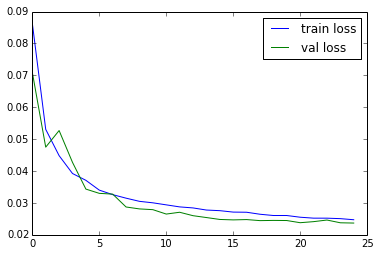

In [13]:
pl.plot(history.history['loss'], label='train loss')
pl.plot(history.history['val_loss'], c='g', label='val loss')
pl.legend()

In [14]:
if False:
    model_dir = '../../models/fcnn'
    json_string = model.to_json()
    open(os.path.join(model_dir, 'architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join(model_dir, 'weights.h5'))

In [15]:
def predict(X):
    Y_pred = model.predict(X)
    Y_pred = Y_pred > 0.2
    for i in range(Y_pred.shape[0]):
        # Clear prediction where we detect to little pixels
        # Figure it out by
        # pl.hist(np.sum(np.sum(np.sum(Y_pred, axis=1), axis=1), axis=1))
        if np.sum(Y_pred[i]) < 400:
            Y_pred[i,:] = 0
    return Y_pred

In [16]:
Y_pred = predict(X_test)

In [17]:
def dice_coefficient(Y_pred, Y):
    """
    http://stackoverflow.com/a/31275008/116067
    """
    denom = (np.sum(Y_pred == 1) + np.sum(Y == 1))
    if denom == 0:
        # By definition, see https://www.kaggle.com/c/ultrasound-nerve-segmentation/details/evaluation
        return 1
    else:
        return 2 * np.sum(Y[Y_pred == 1]) / denom
    
print "test set score : ", dice_coefficient(Y_pred, Y_test)

test set score :  0.577535938449


In [18]:
# Find the images with lowest scores
dice_scores = []
for i in range(Y_pred.shape[0]):
    dice_scores.append(dice_coefficient(Y_pred[i], Y_test[i]))
dice_scores = np.array(dice_scores)
lowest = np.argsort(dice_scores)

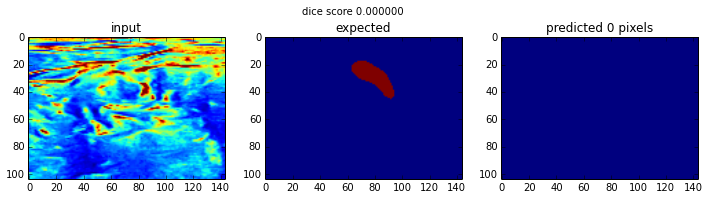

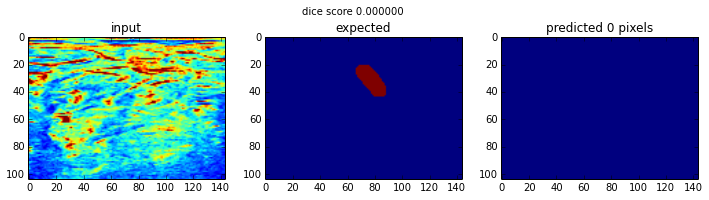

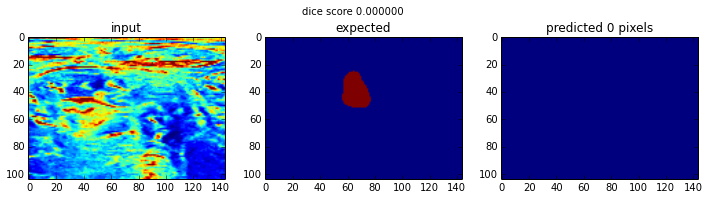

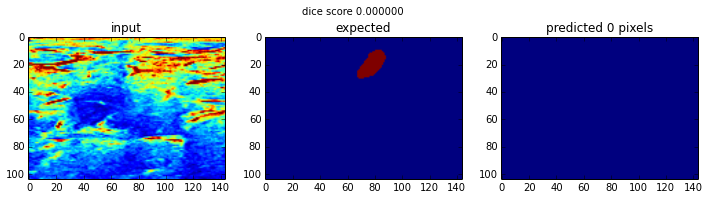

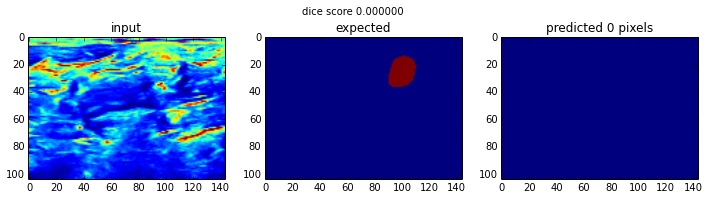

In [19]:
#i = 50
#i = 47

#for i in lowest[-1050:-1045]:
for i in lowest[5:10]:
    pl.figure(figsize=(12, 3))
    pl.suptitle('dice score %f' % dice_coefficient(Y_pred[i], Y_test[i]))
    pl.subplot(131)
    pl.title('input')
    pl.imshow(X_test[i].squeeze())
    pl.subplot(132)
    pl.title('expected')
    pl.imshow(Y_test[i].squeeze())
    pl.subplot(133)
    pl.title('predicted %d pixels' % np.sum(Y_pred[i]))
    pl.imshow(Y_pred[i].squeeze(), vmin=0, vmax=1)

# Run the model on kaggle'7 test set

In [50]:
_d = np.load('../../data_test.npz')
X_submit = _d['X']
test_fnames = _d['test_fnames']
Y_pred = predict(X_submit[:,None,:,:])

In [51]:
Y_pred.shape

(5508, 1, 104, 144)

In [54]:
OUTDIR='../../preds'
if os.path.exists(OUTDIR):
    shutil.rmtree(OUTDIR)
utils.mkdir_p(OUTDIR)

for i in range(Y_pred.shape[0]):
    imre = cv2.resize((Y_pred[i].squeeze() * 255).astype(np.uint8), (580, 420))
    basename = os.path.splitext(test_fnames[i])[0]
    cv2.imwrite(os.path.join(OUTDIR, basename + '.png'), imre)

# Visualization stuff

('W shape : ', (16, 5, 5))


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


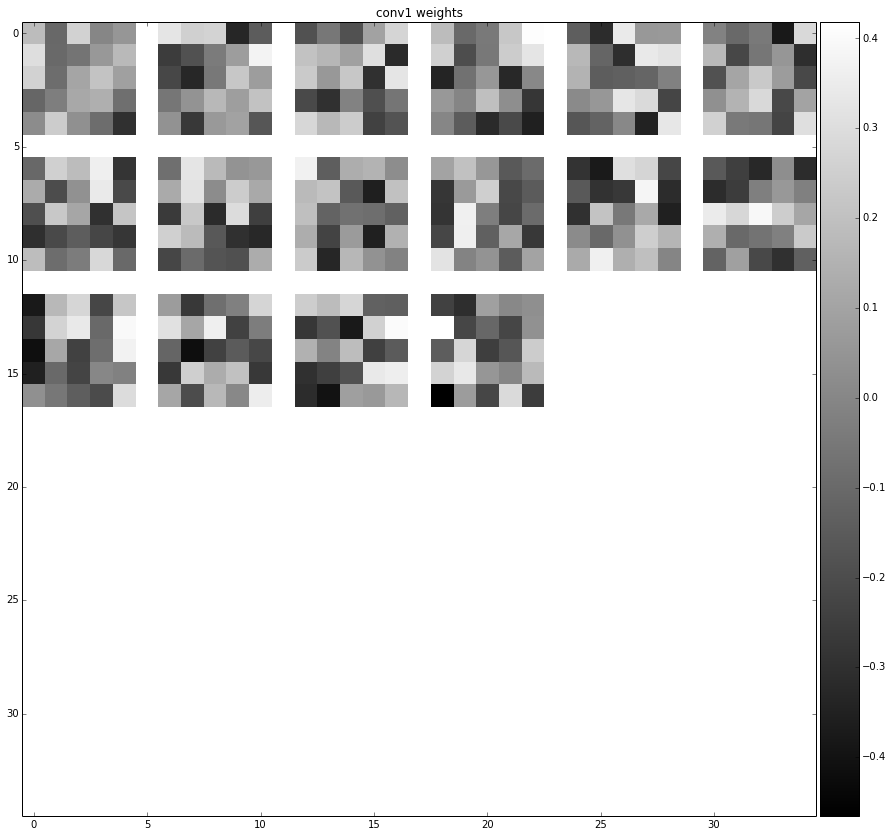

In [72]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma

def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)
    
# Visualize weights
W = model.layers[1].W.get_value(borrow=True)
W = np.squeeze(W)
print("W shape : ", W.shape)

mosaic = make_mosaic(W, 6, 6)

pl.figure(figsize=(15, 15))
pl.title('conv1 weights')
nice_imshow(pl.gca(), mosaic, cmap=cm.gray)

In [73]:
def find_layer(name):
    for l in model.layers:
        if l.name == name:
            return l
    else:
        return None
find_layer('pool1')

In [55]:
from keras import backend as K

def visualize_layer(lname, X):

    # K.learning_phase() is a flag that indicates if the network is in training or
    # predict phase. It allow layer (e.g. Dropout) to only be applied during training
    inputs = [K.learning_phase()] + model.inputs

    _f = K.function(inputs, [find_layer(lname).output])
    def f(X):
        # The [0] is to disable the training phase flag
        return _f([0] + [X])
    
    # Visualize convolution result (after activation)
    C1 = f(X)
    C1 = np.squeeze(C1)
    print("C1 shape : ", C1.shape)

    pl.figure(figsize=(10, 8))
    nice_imshow(pl.gca(), make_mosaic(C1, 6, 6), cmap=cm.binary)
    
#visualize_layer('pool1', X_test[i][None, :, :, :])
visualize_layer('pool3', X_test[i][None, :, :, :])

IndexError: index 5507 is out of bounds for axis 0 with size 1409

In [24]:
# CPU chunked version
import sys

if False
    batch_size = 32
    for epoch in range(5):
        order = np.arange(X_train.shape[0])
        np.random.shuffle(order)
        for i in range(0, len(order), batch_size):
            indices = order[i:i+batch_size]
            _X_train = X_train[indices]
            _Y_train = Y_train[indices]
            history = model.fit(_X_train, _Y_train, nb_epoch=1)
            print history
            sys.stdout.flush()

SyntaxError: invalid syntax (<ipython-input-24-9c267c222358>, line 4)